## 밑바닥부터 시작하는 딥러닝(Deep Learning from Scratch) 챕터별 예제코드 정리 
예제코드가 기본이나 정확히 일치하지는 않습니다. 개인적으로 모든 코드들을 문서화하되 너무 기본적인 내용은 제외하거나 나름대로 더 필요하다고 생각되는 내용은 추가하였습니다. 같은 내용을 다른 방식으로 구현하는 경우도 있습니다.
## Chapter 6. 학습 관련 기술들
### 6.1 Optimization method
아래의 링크에서 좀 더 상세한 내용을 확인이 가능하니 참고할 것  
http://cs231n.github.io/neural-networks-3/#sgd  
http://newsight.tistory.com/224

### Stochastic gradient descent (SGD)
$$\theta_{t} \leftarrow \theta_{t-1}-{\eta}\nabla f(\theta_{t-1})$$

In [1]:
# SGD (Stochastic gradient descent)
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr

    def update(self, params, grads):

        for key in params.keys():
            params[key] -= self.lr * grads[key]

### Momentum
$$v_{t-1} \leftarrow \mu v_{t-2} - \eta \nabla f(\theta_{t-1})$$  

$$\theta_t \leftarrow \theta_{t-1} + v_{t-1}$$

In [2]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = { }
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### Nesterov
$$ v_{t-1} \leftarrow \mu v_{t-2} - \eta \nabla f(\theta_{t-1} + \mu v_{t-2})$$
$$ \theta_t \leftarrow \theta_{t-1} + v_{t-1} $$

In [3]:
class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

### AdaGrad
학습률(learning rate)을 gradient update 양에 맞추어 변경 (각각의 parameter에 맞게)

$$cache \leftarrow cache + \nabla f(\theta) \odot \nabla f(\theta)$$  

$$\theta_t \leftarrow \theta_{t-1} - \eta {{1} \over \sqrt{cache}} \nabla f(\theta_{t-1})$$

In [1]:
# AdaGrad
# Idea : learning rate decay depends on each dimension
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 0으로 나누는 것을 방지

### RMSprop
AdaGrad와 마찬가지의 idea이나 좀 개량된 형태, 위의 cache에 대해서 exponenital smoothing 기법을 활용

In [5]:
# RMSprop
# Idea : learning rate decay depends on each dimension by exponential smoothing
# Source : Jeffrey hinton's course note
class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam 
개념적으로는 RMSprop에 Momentum 방법을 결합한 것과 비슷하게 생각할 수 있다.

In [6]:
# Adam
# Idea : RMSprop + Momentum (a bit like)
class Adam:
    def __init__(self, lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

        for key in params.keys():
            # self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            # self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            # unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            # unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            # params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### Comparision
위에 소개한 모든 방법을 비교하지는 않고 SGD, Momentum, AdaGrad, Adam을 아래의 함수에 대해서 비교한다. 아래의 함수는 (0,0)에서 최소값을 가지나 gradient의 경향성을 시각화해보았을 때, 대부분의 gradient의 감소방향은 (0,0)을 가르키지 않는 것을 확인가능하다. 또한 y축으로 보았을 때 감소하는 gradient의 방향의 gradient의 크기가 x축으로 보았을 때 gradiet가 감소하는 방향의 gradient의 크기보다 훨씬 큼을 확인가능하다.
  
 $$f(x,y)={x^2 \over 20}+y^2 $$

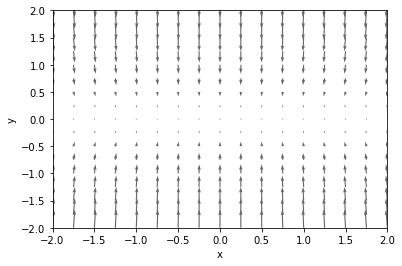

In [7]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from collections import OrderedDict
def f(x, y):
    return x ** 2 / 20.0 + y ** 2
def df(x, y):
    return x / 10.0, 2.0 * y

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

plt.figure()
plt.quiver(X, Y, -df(X, Y)[0], -df(X, Y)[1], angles="xy", color="#666666")  # ,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.draw()
plt.show()

위의 함수에 대하여 특정한 초기점을 주고 함수가 최소값이 되는 (x,y)를 찾아가도록 언급한 네가지의 Optimization 방법론을 적용한 결과는 아래와 같다. SGD의 경우 단순 해당 점의 gradient값에만 의존하기때문에 최소값이 되는 점을 찾아갈 때 굉장히 지그재그 움직이면서 찾아간 것을 볼 수있다. 반면에 Momentum의 경우 전의 변화량을 어느정도 반영하므로 지그재그 현상이 많이 완화된 것을 볼 수 있고, AdaGrad, Adam 같은 learning rate annealing이 적용된 방법은 지그재그가 더 덜함을 알 수 있다. 또한 아래의 코드에서는 각 Optimization 방법론마다 learning rate를 다르게 지정하였는데 이는 SGD 같은 경우는 학습률이 너무 작으면 수렴하지않고, Momentum 같은 경우는 학습률이 너무 크면 발산해 버리기 때문이다. 반면에 AdaGrad나 Adam 같은 방법론은 learning rate annealing 방법이 적용되어 있으므로 초기에 learning rate를 비교적 큰 값을 주어도 학습이 이루어진다.

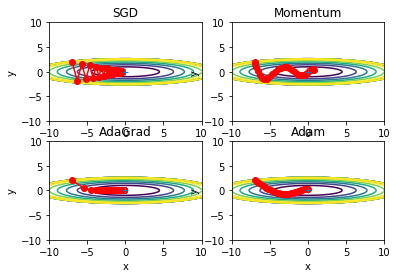

In [8]:
# comparison
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)


    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()

학습률을 동일하게 모두 큰값으로 주면 SGD나 Momentum 같은 경우는 발산하나 AdaGrad나 Adam은 어느 정도 수렴을 확인할 수 있다.

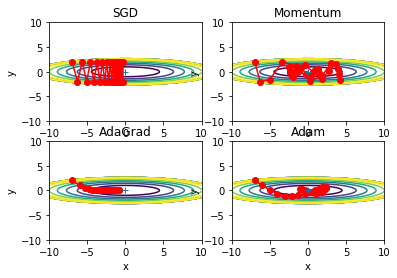

In [9]:
# comparison
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=1)
optimizers["Momentum"] = Momentum(lr=1)
optimizers["AdaGrad"] = AdaGrad(lr=1)
optimizers["Adam"] = Adam(lr=1)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)


    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()